In [1]:
import datetime
import os
import random

import keras
import numpy as np
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.layers import (Activation, BatchNormalization, Dense,
                                     Dropout, Flatten, Reshape, Input,
                                     TimeDistributed)
from tensorflow.keras.models import Model

tf.compat.v1.disable_eager_execution()

import midi

In [2]:
NUM_EPOCHS = 50
DO_RATE = 0.1
BN_M = 0.9
BATCH_SIZE = 128
PARAM_SIZE = 72

np.random.seed(0)
random.seed(0)

In [3]:
y = np.load('pypianorollSamples.npy')
y = y.reshape(len(y) * 4, 512, 72)
y_shape = y.shape

In [4]:
y_train = y[:int(y.shape[0]*0.80)]
y_valid = y[int(y.shape[0]*0.80):y.shape[0]]

y_test_song = np.copy(y[0])

In [5]:
class Sampling(keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs 
        return K.random_normal(tf.shape(log_var), stddev=0.1) * K.exp(log_var / 2) + mean


In [6]:
x_in = Input(shape=y_shape[1:])
z = TimeDistributed(Dense(36, activation='relu'))(x_in)
z = TimeDistributed(Dense(8, activation='relu'))(z)
z = Flatten()(z)
z = Dense(2048, activation='relu')(z)
# z = BatchNormalization()(z)
z = Dense(1024, activation='relu')(z)
# z = BatchNormalization()(z)
z = Dense(512, activation='relu')(z)
z = Dense(256, activation='relu')(z)
# z = BatchNormalization()(z)
codings_mean = Dense(PARAM_SIZE)(z)
codings_log_var = Dense(PARAM_SIZE)(z)
codings = Sampling()([codings_mean, codings_log_var])
variational_encoder = Model(inputs=[x_in], outputs=[codings_mean, codings_log_var, codings])

In [7]:
# variational_encoder.summary()

In [8]:
decoder_inputs = Input(shape=[PARAM_SIZE])
x = Dense(PARAM_SIZE,  name= 'encoder')(decoder_inputs)
x = BatchNormalization(momentum=BN_M)(x)
x = Activation("relu")(x)
x = Dropout(DO_RATE)(x)
x = Dense(256, activation='relu')(x)
x = Dense(512, activation='relu')(x)
x = Dropout(DO_RATE)(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(DO_RATE)(x)
x = Dense(2048, activation='relu')(x)
x = Dropout(DO_RATE)(x)
x = Dense(4096, activation='relu')(x)
x = Reshape((512,8))(x)
x = TimeDistributed(Dense(36))(x)
x = TimeDistributed(BatchNormalization(momentum=BN_M))(x)
x = Activation("relu")(x)
x = Dropout(DO_RATE)(x)
x = TimeDistributed(Dense(72))(x)
outputs = Reshape((512,72))(x)
variational_decoder = Model(inputs=[decoder_inputs], outputs=[x])

Instructions for updating:
Colocations handled automatically by placer.


2022-07-07 21:42:48.996325: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-07 21:42:49.029431: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-07 21:42:49.029689: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [9]:
# variational_decoder.summary()

In [10]:
_, _, codings = variational_encoder(x_in)
reconstructions = variational_decoder(codings)
variational_ae = keras.Model(inputs=[x_in], outputs=[reconstructions])

latent_loss = -0.5 * K.sum(
1 + codings_log_var - K.exp(codings_log_var) - K.square(codings_mean),
axis=-1)

variational_ae.add_loss(K.mean(latent_loss) * 10000 / 36864.)
variational_ae.compile(loss="binary_crossentropy", optimizer="rmsprop")

2022-07-07 21:42:49.641393: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-07 21:42:49.642988: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-07 21:42:49.643284: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-07 21:42:49.643422: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

In [11]:
log_dir = os.path.join(
    "logs",
    datetime.datetime.now().strftime("%Y%m%d-%H%M%S"),
)
callbacks = [
    tf.keras.callbacks.TensorBoard(log_dir=log_dir),
]

history = variational_ae.fit(
    y_train,
    y_train,
    callbacks=callbacks,
    epochs=NUM_EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(y_valid, y_valid),
    verbose=2,
)

loss = history.history["loss"][-1]
print(f"Train Loss: {loss}")

write_dir = 'HistoryVAAuto/'
variational_ae.save('HistoryVAAuto/variational_ae.h5')

Train on 5900 samples, validate on 1476 samples
Epoch 1/50


2022-07-07 21:42:53.692224: I tensorflow/core/profiler/lib/profiler_session.cc:99] Profiler session initializing.
2022-07-07 21:42:53.692253: I tensorflow/core/profiler/lib/profiler_session.cc:114] Profiler session started.
2022-07-07 21:42:53.692282: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1665] Profiler found 1 GPUs
2022-07-07 21:42:53.692773: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcupti.so.11.2'; dlerror: libcupti.so.11.2: cannot open shared object file: No such file or directory
2022-07-07 21:42:53.973790: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-07-07 21:42:53.974580: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1799] CUPTI activity buffer flushed
2022-07-07 21:42:54.013164: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:521]  GpuTracer has collected 822 callback api events and 826 activity events. 
2022-07-07 21:42:54.029274: I te

5900/5900 - 5s - loss: 0.3286 - val_loss: 0.0548 - 5s/epoch - 852us/sample
Epoch 2/50
5900/5900 - 2s - loss: 0.0548 - val_loss: 0.0460 - 2s/epoch - 406us/sample
Epoch 3/50
5900/5900 - 2s - loss: 0.0525 - val_loss: 0.0477 - 2s/epoch - 411us/sample
Epoch 4/50
5900/5900 - 2s - loss: 0.0524 - val_loss: 0.0458 - 2s/epoch - 419us/sample
Epoch 5/50
5900/5900 - 3s - loss: 0.0524 - val_loss: 0.0442 - 3s/epoch - 432us/sample
Epoch 6/50
5900/5900 - 3s - loss: 0.0524 - val_loss: 0.0453 - 3s/epoch - 428us/sample
Epoch 7/50
5900/5900 - 2s - loss: 0.0524 - val_loss: 0.0449 - 2s/epoch - 409us/sample
Epoch 8/50
5900/5900 - 2s - loss: 0.0524 - val_loss: 0.0442 - 2s/epoch - 418us/sample
Epoch 9/50
5900/5900 - 2s - loss: 0.0524 - val_loss: 0.0441 - 2s/epoch - 421us/sample
Epoch 10/50
5900/5900 - 2s - loss: 0.0524 - val_loss: 0.0441 - 2s/epoch - 410us/sample
Epoch 11/50
5900/5900 - 3s - loss: 0.0524 - val_loss: 0.0441 - 3s/epoch - 427us/sample
Epoch 12/50
5900/5900 - 3s - loss: 0.0524 - val_loss: 0.0442 - 

In [12]:
import pypianoroll

def sample2midi(path, sample, resolution):
    all_notes = np.zeros((2048,128), dtype=np.uint8)
    all_notes[:, 24:96] = sample.reshape(2048,72)

    pypianoroll.write(
        path=path, 
        multitrack=pypianoroll.Multitrack(
            resolution=resolution,
            tracks=[
                pypianoroll.BinaryTrack(
                    program=0, is_drum=False, pianoroll=all_notes
                    )
                ]
            )
        )

/home/vigrel/Desktop/IC/music-generation/tf2.6/lib/python3.8/site-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


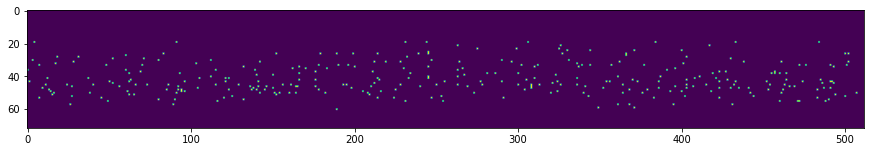

In [13]:
import matplotlib.pyplot as plt
# music = np.expand_dims(np.zeros(y_shape[1:]), axis=0)
music = np.expand_dims(np.random.uniform(size=72), axis=0)
music = variational_decoder.predict(music)
rand_vals = np.random.uniform(size=music.shape)
music = music > rand_vals

plt.figure(figsize=(15,12))
plt.imshow(music[0].transpose())
plt.show()

In [14]:
b

NameError: name 'b' is not defined

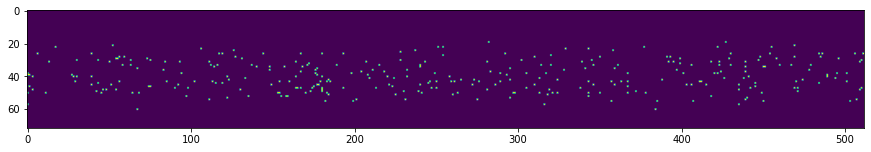

In [16]:
for i in range(1000):
    music = np.expand_dims(np.random.uniform(size=72), axis=0)
    music = variational_decoder.predict(music)
    rand_vals = np.random.uniform(size=music.shape)
    music = music > rand_vals
    music = variational_ae.predict(music)
    music = music > rand_vals

plt.figure(figsize=(15,12))
plt.imshow(music[0].transpose())
plt.show()

In [17]:
midi.sample2midi("teste.mid", music, 4)